In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, HourLocator
from matplotlib.gridspec import GridSpec
from datetime import datetime, timedelta
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.covariance import EmpiricalCovariance
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier
from mpl_toolkits.mplot3d import Axes3D
from glob import glob
import seaborn as sns
from scipy import stats, signal
import warnings
warnings.filterwarnings("ignore")
from ipywidgets import interact, fixed

%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

# 1. 合并文件

In [ ]:
# df = pd.read_excel("../datas/打螺丝数据.xlsx")
files = glob("../datas/打螺丝原始数据/*.csv")

In [3]:
def process_files(file_paths):
    dfs = []
    for file_path in file_paths:
        file_name = os.path.splitext(os.path.basename(file_path))[0]
        parts = file_name.split('_')
        file_info = {
            "prefix": parts[0],               # 前缀（如F9WHHH0003V0000X7U）
            "pos": parts[1],                  # 位置（如pos1）
            "screw_num": parts[2],            # 螺丝数量（如ScrewNum1）
            # "timestamp_str": parts[3],        # 原始时间戳字符串（如2025062813181804）
            "la6": parts[4],                  # 设备标识（如LA6）
            "flow": '_'.join(parts[5:9]),
            # "spk": parts[5],                  # 信号类型（如SPK）
            # "chg": parts[6],                  # 操作类型（如CHG）
            # "to": parts[7],                   # 目标（如TO）
            # "hsg": parts[8],                  # 部件（如HSG）
            "loc": parts[9],                  # 位置详情（如Loc1）
            "version": f'{parts[-2]}_{parts[-1]}'              # 版本号（如V3）
        }
        # .{parts[3][14:].ljust(6, '0')}    .%f
        file_info["datetime"] = pd.to_datetime(f"{parts[3][:14]}", format="%Y%m%d%H%M%S")
        df = pd.read_csv(file_path)
        df.columns = [x.lower() for x in df.columns]
        df["row_in_file"] = df.index   # 文件内行号（从0开始，保留原始顺序）
        for key, value in file_info.items():
            df[key] = value
        dfs.append(df)

    merged_df = pd.concat(dfs, ignore_index=True)
    return merged_df.sort_values(["datetime", "row_in_file"])   # , na_position="last"

In [4]:
df = process_files(files)

# 2. 分析

In [3]:
df = pd.read_csv("../datas/screw.csv")
df

,angle,torque,row_in_file,prefix,pos,screw_num,la6,flow,loc,version,datetime
0,0.00,0.00000,0,F9WHHH000730000X7U,pos4,ScrewNum1,LA6,SPK_CHG_TO_HSG,Loc4,Config_V3,2025-06-28 13:04:17
1,0.00,0.00000,1,F9WHHH000730000X7U,pos4,ScrewNum1,LA6,SPK_CHG_TO_HSG,Loc4,Config_V3,2025-06-28 13:04:17
2,0.00,0.00000,2,F9WHHH000730000X7U,pos4,ScrewNum1,LA6,SPK_CHG_TO_HSG,Loc4,Config_V3,2025-06-28 13:04:17
3,0.00,0.00000,3,F9WHHH000730000X7U,pos4,ScrewNum1,LA6,SPK_CHG_TO_HSG,Loc4,Config_V3,2025-06-28 13:04:17
4,0.00,0.00000,4,F9WHHH000730000X7U,pos4,ScrewNum1,LA6,SPK_CHG_TO_HSG,Loc4,Config_V3,2025-06-28 13:04:17
...,...,...,...,...,...,...,...,...,...,...,...
29295,-6.48,0.33480,572,F9WHHH000490000X7U,pos41,ScrewNum1,LA6,SPK_CHG_TO_HSG,Loc41,Config_V4,2025-06-28 13:39:30
29296,-6.48,0.33585,573,F9WHHH000490000X7U,pos41,ScrewNum1,LA6,SPK_CHG_TO_HSG,Loc41,Config_V4,2025-06-28 13:39:30
29297,-5.94,0.33975,574,F9WHHH000490000X7U,pos41,ScrewNum1,LA6,SPK_CHG_TO_HSG,Loc41,Config_V4,2025-06-28 13:39:30
29298,-5.94,0.34390,575,F9WHHH000490000X7U,pos41,ScrewNum1,LA6,SPK_CHG_TO_HSG,Loc41,Config_V4,2025-06-28 13:39:30


## 2.1 查看趋势

In [41]:
# 4.4 批杆更换候选时间点分析 - 滑动窗口统计量突变
def plotMov(df: pd.DataFrame, cols, window_size):

    df_temp = df.copy().reset_index()
    features = []
    for col in cols:
        # 移动平均（去噪）
        df_temp[f'{col}_ma'] = df_temp[col].rolling(window=window_size, min_periods=1).mean()
        # 移动标准差（检测波动）
        df_temp[f'{col}_std'] = df_temp[col].rolling(window=window_size, min_periods=1).std()

    fig, axs = plt.subplots(2, 1, figsize=(24, 7))
    axs = axs.flatten()
    for idx, col in enumerate(cols):  # 选择关键特征展示
        ax = axs[idx]
        # 绘制移动平均 + 标准差带
        ax.plot(df_temp.index, df_temp[col], alpha=0.3, label='原始值')
        ax.plot(df_temp.index, df_temp[f'{col}_ma'], color='red', label='移动平均')
        ax.fill_between(df_temp.index, 
                        df_temp[f'{col}_ma'] - 2*df_temp[f'{col}_std'], 
                        df_temp[f'{col}_ma'] + 2*df_temp[f'{col}_std'], 
                        color='orange', alpha=0.3, label='2σ范围')
        ax.set_title(f"{col}", fontsize=12)
        ax.legend()
    plt.tight_layout()
    plt.show()

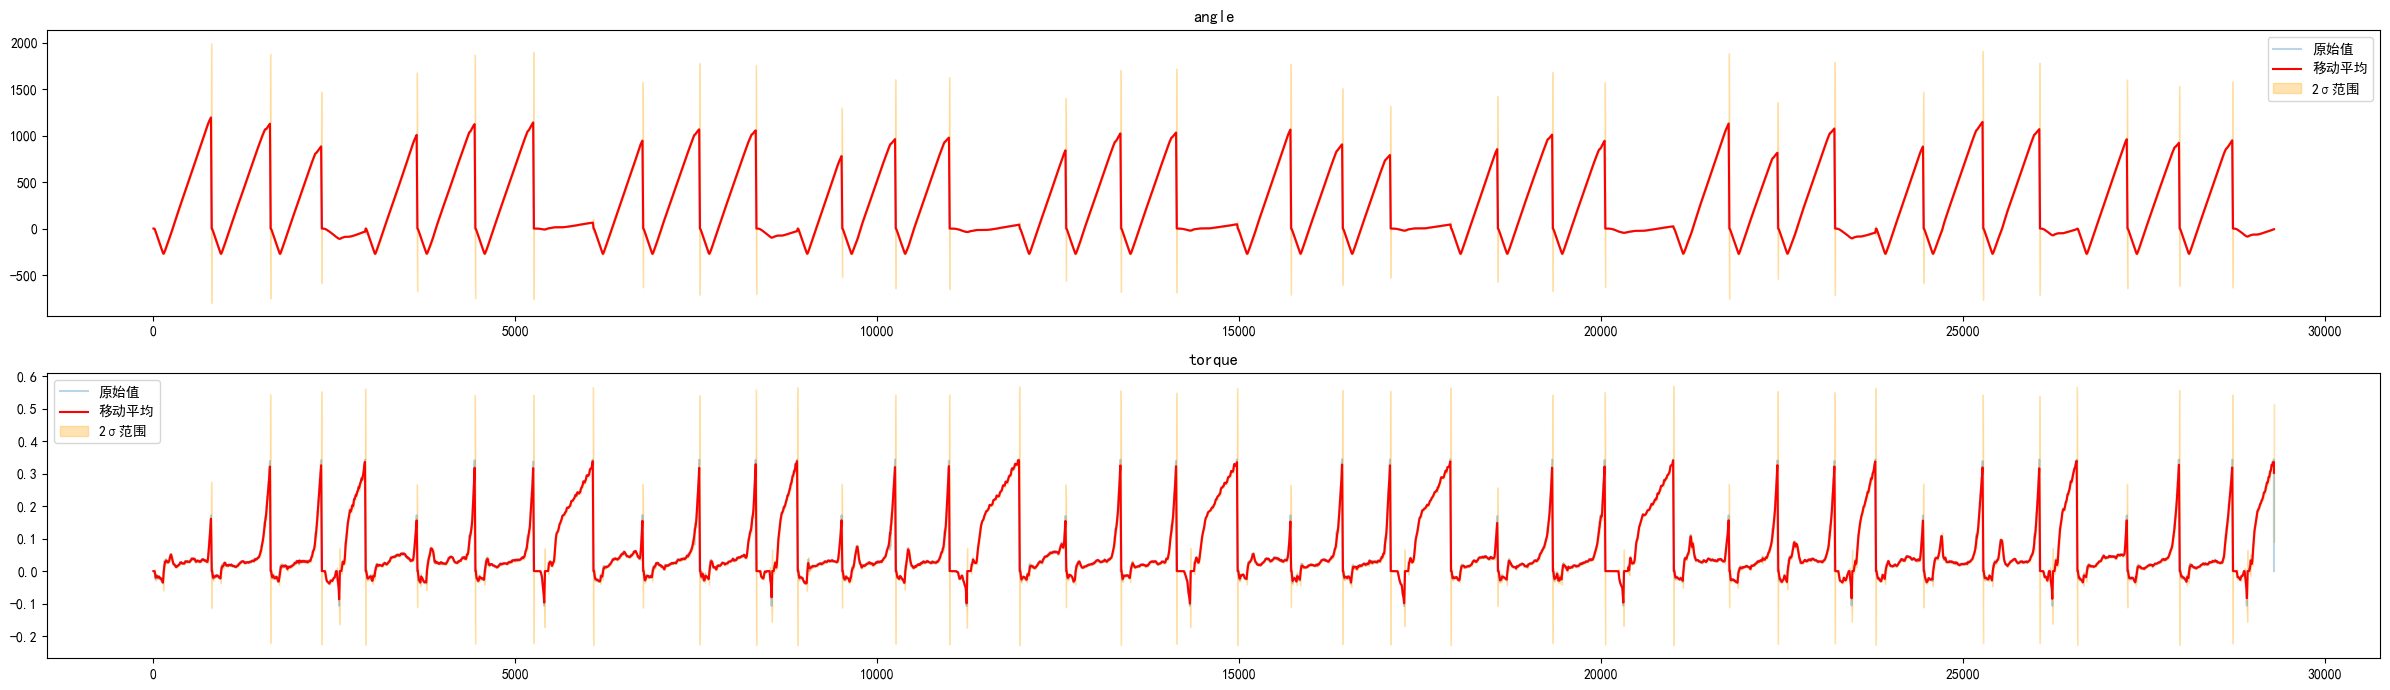

In [42]:
plotMov(df, df.columns[:2], 10)

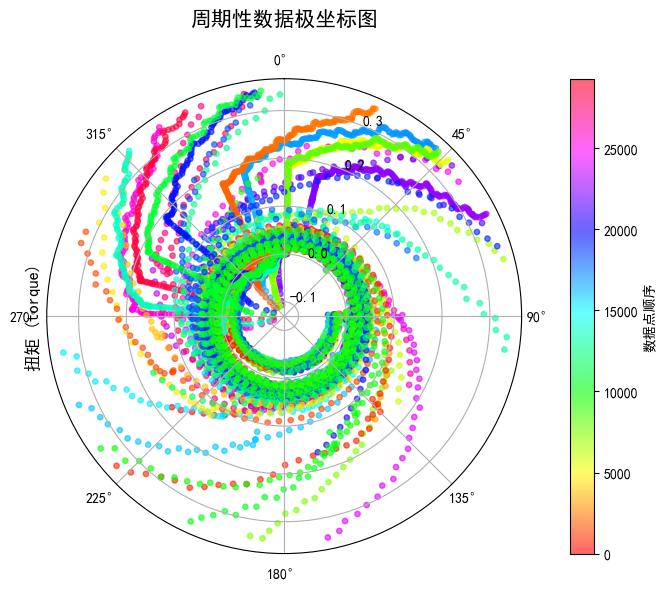

In [ ]:
# 假设 df['angle'] 是角度值（单位：度），先转换为弧度并归一化到 [0, 2π)
df['theta'] = np.deg2rad((df['angle'] % 360))  # 处理负角度和超过360°的情况
df['r'] = df['torque']  # 极径使用扭矩值

# 下采样数据（减少点数量，避免重叠）
downsample_factor = 3  # 每隔10个点取一个样本，根据数据量调整
sampled_df = df.iloc[::downsample_factor]

plt.figure(figsize=(10, 6))

# 创建极坐标子图
ax = plt.subplot(111, projection='polar')

# 绘制散点图（带透明度，重叠点更易区分）
scatter = ax.scatter(
    sampled_df['theta'], 
    sampled_df['r'], 
    c=sampled_df.index,  # 可选：用颜色区分数据点顺序（需数据索引连续）
    cmap='hsv',          # 色相环映射，增强周期性视觉效果
    alpha=0.6,           # 透明度
    marker='o',          # 点型
    s=15                 # 点大小
)

# 添加周期辅助线（显示2π/0角度对齐）
ax.set_theta_offset(np.pi/2)  # 调整0°方向为上方（可选，根据数据特性）
ax.set_theta_direction(-1)     # 逆时针方向为角度增加方向（默认）

# 设置极坐标标签
ax.set_title('周期性数据极坐标图', fontsize=15, pad=20)
ax.set_ylabel('扭矩 (torque)', fontsize=12)
ax.tick_params(axis='x', labelsize=10)  # 调整角度标签字体大小

# 添加颜色条（如果使用了colormap）
plt.colorbar(scatter, label='数据点顺序', ax=ax)

plt.tight_layout()
plt.savefig('polar_plot.png', dpi=300)
plt.show()

## 2.2 异常检测

In [ ]:
class PolarAnomalyDetector:
    def __init__(self, data, n_clusters=8, n_neighbors=5, threshold_factor=2.5):
        """
        初始化极坐标异常检测器
        
        参数:
        - data: 包含'angle', 'torque', 'order'列的数据框
        - n_clusters: 聚类中心数量
        - n_neighbors: KNN中的邻居数量
        - threshold_factor: 异常检测阈值因子
        """
        self.data = data.copy()
        self.n_clusters = n_clusters
        self.n_neighbors = n_neighbors
        self.threshold_factor = threshold_factor
        self.angle_centers = None
        self.training_data = None
        self.normal_cluster_centers = None
        self.anomaly_indices = []

        self.data['order'] = range(1, len(self.data) + 1)
        # 预处理数据
        self.preprocess_data()
        # 训练模型
        self.train_model()
        
    def preprocess_data(self):
        """数据预处理"""
        # 确保角度在[0, 2π]范围内
        self.data['angle_rad'] = np.deg2rad(self.data['angle'])
        self.data['angle_rad'] = self.data['angle_rad'] % (2 * np.pi)
        
        # 对扭矩进行归一化处理
        torque_min = self.data['torque'].min()
        torque_max = self.data['torque'].max()
        self.data['torque_normalized'] = (self.data['torque'] - torque_min) / (torque_max - torque_min)
        
        # 将数据转换为NumPy数组 [angle_rad, torque_normalized, order]
        self.training_data = self.data[['angle_rad', 'torque_normalized', 'order']].values
        
    def train_model(self):
        """训练模型"""
        # 使用K-means对正常数据进行聚类
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(self.training_data[:, :2])
        self.normal_cluster_centers = kmeans.cluster_centers_
        
        # 计算每个点到其最近邻的距离
        neigh = NearestNeighbors(n_neighbors=self.n_neighbors)
        neigh.fit(self.training_data[:, :2])
        distances, _ = neigh.kneighbors(self.training_data[:, :2])
        self.normal_distances = np.median(distances, axis=0)
        
        # 计算每个聚类的平均扭矩
        cluster_torques = []
        for i in range(self.n_clusters):
            mask = (cluster_labels == i)
            if np.any(mask):
                cluster_torques.append(np.median(self.training_data[mask, 1]))
            else:
                cluster_torques.append(0)
        self.cluster_torque_medians = np.array(cluster_torques)
        
    def detect_anomalies(self, data=None):
        """
        检测异常并更新异常索引
        
        参数:
        - data: 要检测的数据，默认使用训练数据
        
        返回:
        - 异常数据的DataFrame
        """
        if data is None:
            if self.training_data is None:
                print("警告: 训练数据为空")
                return []
            X = self.training_data
        else:
            # 预处理输入数据
            X_rad = data['angle_rad'].values
            X_torque = data['torque_normalized'].values
            X_order = data['order'].values
            X = np.column_stack((X_rad, X_torque, X_order))
        
        anomalies = []
        for i, point in enumerate(X):
            # 1. 点到聚类中心距离异常检测
            cluster_dist = np.linalg.norm(point[:2] - self.normal_cluster_centers, axis=1)
            min_dist_idx = np.argmin(cluster_dist)
            if min_dist_idx < len(self.normal_distances):
                is_anomaly_by_dist = (cluster_dist[min_dist_idx] > 2 * self.normal_distances[min_dist_idx])
            else:
                # 如果索引越界，直接标记为异常
                is_anomaly_by_dist = True
            
            # 2. 异常顺序扭矩变化检测
            point_angle = point[0]
            nearest_idx = np.argmin(np.abs(self.normal_cluster_centers[:, 0] - point_angle))
            expected_torque = self.cluster_torque_medians[nearest_idx]
            actual_torque = point[1]
            torque_deviation = np.abs(actual_torque - expected_torque) / (expected_torque + 1e-8)
            is_anomaly_by_torque = (torque_deviation > self.threshold_factor)
            
            # 3. 点序连续性检测（如果提供了完整数据）
            is_anomaly_by_order = False
            if len(X) > 1 and i < len(X) - 1:
                next_point = X[i+1] if i+1 < len(X) else X[i-1]
                angle_diff = np.abs(point[0] - next_point[0])
                torque_diff = np.abs(point[1] - next_point[1])
                is_anomaly_by_order = (angle_diff > np.pi/2 or torque_diff > 0.5)
            
            if is_anomaly_by_dist or is_anomaly_by_torque or is_anomaly_by_order:
                anomalies.append(i if data is self.training_data else point)
        
        # 更新异常索引
        if data is self.training_data:
            self.anomaly_indices = anomalies
        return anomalies
    
    def visualize_results(self, figsize=(15, 8)):
        """可视化检测结果"""
        plt.figure(figsize=figsize)
        
        # 绘制正常数据点
        normal_mask = np.ones(len(self.training_data), dtype=bool)
        if self.anomaly_indices:
            normal_mask[self.anomaly_indices] = False
        normal_data = self.training_data[normal_mask]
        
        # 角度从0开始
        angles = np.unwrap(normal_data[:, 0])
        angles[angles < 0] += 2 * np.pi
        
        # 创建子图1：极坐标图
        plt.subplot(121, polar=True)
        plt.scatter(angles, normal_data[:, 1], c='blue', alpha=0.6, s=10, label='Normal')
        
        if self.anomaly_indices:
            anomaly_data = self.training_data[self.anomaly_indices]
            angles_anom = np.unwrap(anomaly_data[:, 0])
            angles_anom[angles_anom < 0] += 2 * np.pi
            
            plt.scatter(angles_anom, anomaly_data[:, 1], c='red', alpha=0.6, s=10, label='Anomaly')
        
        plt.title('Polar Anomaly Detection')
        plt.legend()
        plt.grid(True)
        
        # 创建子图2：参数空间图
        plt.subplot(122)
        plt.scatter(self.training_data[normal_mask, 0], self.training_data[normal_mask, 1], c='blue', alpha=0.6, s=10)
        
        if self.anomaly_indices:
            plt.scatter(anomaly_data[:, 0], anomaly_data[:, 1], c='red', alpha=0.6, s=10, label='Anomaly')
        
        plt.xlabel('Angle (rad)')
        plt.ylabel('Normalized Torque')
        plt.title('Parameter Space View')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

In [72]:
detector = PolarAnomalyDetector(df)

In [73]:
anomalies = detector.detect_anomalies()
anomalies

[array([0.        , 0.23773668, 1.        ]),
 array([0.        , 0.23773668, 2.        ]),
 array([0.        , 0.23773668, 3.        ]),
 array([0.        , 0.23773668, 4.        ]),
 array([0.        , 0.23773668, 5.        ]),
 array([0.        , 0.23773668, 6.        ]),
 array([6.27376053, 0.23773668, 7.        ]),
 array([6.26433575, 0.23773668, 8.        ]),
 array([6.25491097, 0.23773668, 9.        ]),
 array([ 6.2454862 ,  0.23773668, 10.        ]),
 array([ 6.23606142,  0.23773668, 11.        ]),
 array([ 6.21721186,  0.23773668, 12.        ]),
 array([ 6.18893753,  0.23773668, 13.        ]),
 array([ 6.16066319,  0.23773668, 14.        ]),
 array([ 6.13238886,  0.23773668, 15.        ]),
 array([ 6.09468975,  0.23064998, 16.        ]),
 array([ 6.05699064,  0.2169195 , 17.        ]),
 array([ 6.01929152,  0.21326542, 18.        ]),
 array([ 5.98159241,  0.2117152 , 19.        ]),
 array([ 5.9438933 ,  0.21038645, 20.        ]),
 array([ 5.90619419,  0.21060791, 21.        ])

In [93]:
def optimize_anomaly_detection(data_points, is_polar=True, n_components=2, n_neighbors=20, radius=0.1, min_samples=5, alpha=0.9):
    """
    优化的异常检测算法
    
    参数:
    data_points : numpy.ndarray, shape (n_samples, n_features)
        输入数据点
    is_polar : bool, optional (default=True)
        指示输入是否已经是极坐标形式 (r, theta)
    n_components : int, optional (default=2)
        PCA降维的维度
    n_neighbors : int, optional (default=20)
        算法的邻居数量
    radius : float, optional (default=0.1)
        DBSCAN的邻域半径
    min_samples : int, optional (default=5)
        DBSCAN和LOF的最小样本数
    alpha : float, optional (default=0.9)
        异常分数阈值
    
    返回:
    is_anomaly : numpy.ndarray, shape (n_samples,)
        布尔值数组，指示每个点是否为异常点
    """
    # 数据预处理
    X = data_points.copy()
    # 如果是极坐标数据，转换为笛卡尔特征
    if is_polar:
        r = X[:, 0]
        theta = X[:, 1]
        
        # 角度转换为周期特征
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        
        # 添加频域特征
        X = np.column_stack([r, r * cos_theta, r * sin_theta, np.sin(2 * theta), np.cos(2 * theta), np.abs(np.fft.fft(r*cos_theta + r*sin_theta))])  # 一阶谐波幅值
    
    # 步骤1: 使用PCA降维
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    
    # 步骤2: DBSCAN聚类
    from sklearn.cluster import DBSCAN
    db = DBSCAN(eps=radius, min_samples=min_samples).fit(X_pca)
    cluster_labels = db.labels_
    
    # 步骤3: 计算局部密度和孤立森林异常分数
    from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
    from sklearn.ensemble import IsolationForest
    
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    nbrs = neigh.fit(X_pca)
    distances, _ = nbrs.kneighbors(X_pca)
    
    # 局部离群因子
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=0.1)
    lof_scores = -lof.fit_predict(X_pca)
    
    # 孤立森林
    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    iso_scores = -iso_forest.fit_predict(X_pca)
    
    # 步骤4: 参数空间特定处理
    if len(data_points.shape) > 1 and data_points.shape[1] == 2 and not is_polar:
        angle = data_points[:, 0]
        torque = data_points[:, 1]
        
        # 边界异常检测
        boundary_mask = (
            (np.abs(angle - 0) < 0.2) | 
            (np.abs(angle - 6) < 0.2) | 
            (np.abs(torque - 0) < 0.05) | 
            (np.abs(torque - 1) < 0.05)
        )
        
        # 高扭矩异常检测
        high_torque_mask = torque > 0.85
        
        # 结合通用和特定分数
        combined_scores = 0.7 * lof_scores + 0.3 * (2.0 * boundary_mask.astype(float) + 1.5 * high_torque_mask.astype(float))
    else:
        # 步骤5: 综合异常分数
        # 权重分配：LOF(0.4) + 孤立森林(0.3) + 密度(0.3)
        density_factor = (np.min(distances[:, 1:], axis=1) - np.min(distances[:, 1:])) / (np.max(distances[:, 1:]) - np.min(distances[:, 1:]))
        
        combined_scores = 0.4 * lof_scores + 0.3 * iso_scores + 0.3 * density_factor
    
    # 步骤6: 最终异常判定
    threshold = np.quantile(combined_scores, alpha)
    is_anomaly = combined_scores > threshold

    return is_anomaly

In [79]:
df.columns

Index(['angle', 'torque', 'row_in_file', 'prefix', 'pos', 'screw_num', 'la6',
       'flow', 'loc', 'version', 'datetime', 'theta', 'r'],
      dtype='object')

In [94]:
data_points = np.array(df[['r', 'theta']])
is_anomaly = optimize_anomaly_detection(data_points, True)

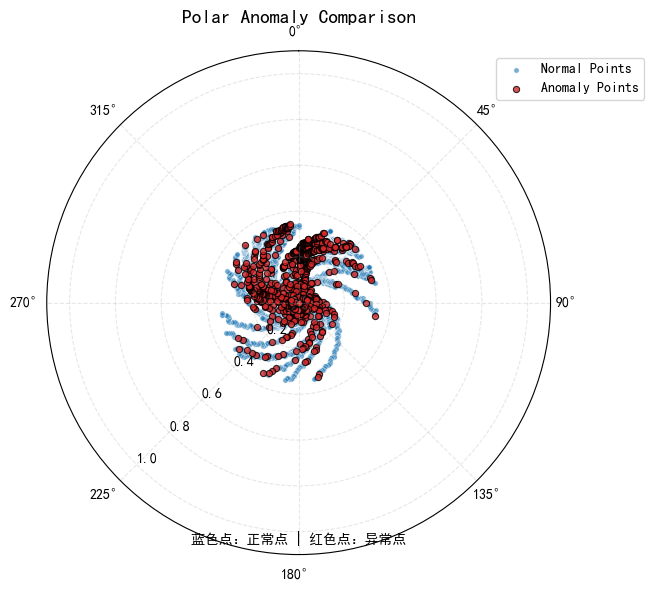

In [ ]:
def plot_anomaly_comparison(data_points, is_anomaly, title="Polar Anomaly Comparison"):
    """
    绘制极坐标下的正常点与异常点对比图
    
    参数:
    data_points : DataFrame, 包含 'r'（半径）和 'theta'（角度）列
    is_anomaly : array-like, 布尔型数组，标记每个点是否为异常点
    title : str, 图表标题
    """
    df_data = pd.DataFrame(data_points, columns=['r', 'theta'])
    # 分离正常点和异常点
    normal_mask = ~np.array(is_anomaly)
    anomaly_mask = np.array(is_anomaly)
    
    # 准备数据
    r_normal = df_data.loc[normal_mask, 'r'].values
    theta_normal = df_data.loc[normal_mask, 'theta'].values
    r_anomaly = df_data.loc[anomaly_mask, 'r'].values
    theta_anomaly = df_data.loc[anomaly_mask, 'theta'].values
    
    # 创建极坐标子图
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, polar=True) 
    
    # 角度转换为显示标签（0°, 45°, ..., 315°）
    angle_labels = [f"{int(angle*180/np.pi)}°" for angle in np.linspace(0, 2*np.pi, 8, endpoint=False)]
    
    # 绘制正常点（使用径向距离表示幅度，角度表示相位）
    scatter_normal = ax.scatter(theta_normal, r_normal, c='#1f77b4', s=15, alpha=0.6, label='Normal Points', linewidths=0.5, edgecolors='w')
    # 绘制异常点（红色高亮）
    scatter_anomaly = ax.scatter(theta_anomaly, r_anomaly, c='#d62728', s=20, alpha=0.8, label='Anomaly Points', linewidths=0.8, edgecolors='k')
    
    # 设置极坐标参数
    ax.set_theta_zero_location('N')  # 0°指向北方
    ax.set_theta_direction(-1)       # 顺时针方向（常规极坐标方向）
    ax.set_xticks(np.linspace(0, 2*np.pi, 8, endpoint=False))
    ax.set_xticklabels(angle_labels)
    ax.set_rlim(0, 1.1)             # 设置半径显示范围（根据数据调整）
    ax.set_rlabel_position(225)     # 半径标签位置（左下45°）
    ax.grid(alpha=0.3, linestyle='--')
    
    # 添加图例和标题
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0), frameon=True)
    plt.title(title, fontsize=14, pad=20)
    
    # 添加辅助说明文本（可选）
    plt.text(0.5, 0.02, '蓝色点：正常点 | 红色点：异常点', transform=ax.transAxes, ha='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# 使用示例（假设已有数据和检测结果）
# 假设df是包含'r'和'theta'列的DataFrame，is_anomaly是布尔数组
plot_anomaly_comparison(data_points, is_anomaly)

# 3. 异常检测

## 3.1 方案一

### 3.1.1 预处理

In [13]:
def preprocess_screw_data(df):
    """
    整理螺丝实例：根据prefix和loc合并同一螺丝的多阶段数据
    规则：loc=4和41视为同一螺丝的两个阶段，loc1/2为完整过程（示例规则，需根据实际调整）
    """
    # 标记特殊loc对应的螺丝阶段（示例逻辑，需根据业务调整）
    df['screw_group'] = df['loc'].apply(lambda x: 
        'group_4' if x in ['Loc4', 'Loc41'] else  # 合并loc4和41为一个螺丝组
        'group_1' if x == 'Loc1' else         # loc1为独立螺丝
        'group_2' if x == 'Loc2' else         # loc2为独立螺丝
        'other'                     # 其他loc单独成组
    )
    
    # 按prefix+screw_group分组，合并同一螺丝的所有阶段数据
    # 假设每个螺丝的多个阶段按时间顺序排列，取时间范围合并
    grouped = df.groupby(['prefix', 'screw_group'])
    screw_data = []
    
    for (prefix, group_key), group_df in grouped:
        # 按时间排序（确保阶段顺序正确）
        group_df = group_df.sort_values(['datetime', 'row_in_file'])
        # 合并角度和扭力的时间序列（假设每个阶段的时间连续）
        merged_angle = np.concatenate(group_df['angle'].apply(lambda x: np.array(x).flatten()).values)
        merged_torque = np.concatenate(group_df['torque'].apply(lambda x: np.array(x).flatten()).values)
        # 记录元信息（如总螺丝数、阶段数等）
        meta = {
            'prefix': prefix,
            'screw_group': group_key,
            'start_time': group_df['datetime'].min(),
            'end_time': group_df['datetime'].max(),
            'num_stages': len(group_df),  # 阶段数（如loc4和41对应2阶段）
            'merged_angle': merged_angle,
            'merged_torque': merged_torque
        }
        screw_data.append(meta)
    
    return pd.DataFrame(screw_data)

# 执行预处理，得到每个螺丝的完整时间序列数据
screw_df = preprocess_screw_data(df)
print("预处理后螺丝实例示例：")
screw_df

预处理后螺丝实例示例：


,prefix,screw_group,start_time,end_time,num_stages,merged_angle,merged_torque
0,F9WHHH0003V0000X7U,group_1,2025-06-28 13:18:18,2025-06-28 13:18:18,725,"[0.0, 0.0, 0.0, 0.0, 0.0, -0.54, -0.54, -1.08,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,F9WHHH0003V0000X7U,group_2,2025-06-28 13:18:08,2025-06-28 13:18:08,759,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.54, -1.08, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,F9WHHH0003V0000X7U,group_4,2025-06-28 13:17:58,2025-06-28 13:18:20,1594,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.54, -1.08, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,F9WHHH000450000X7U,group_1,2025-06-28 13:14:05,2025-06-28 13:14:05,769,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.54, -1.08, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,F9WHHH000450000X7U,group_2,2025-06-28 13:13:55,2025-06-28 13:13:55,759,"[0.0, 0.0, 0.0, 0.0, 0.0, -0.54, -0.54, -1.08,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,F9WHHH000450000X7U,group_4,2025-06-28 13:13:45,2025-06-28 13:14:08,1483,"[0.0, 0.0, 0.0, 0.0, 0.0, -0.54, -1.08, -1.62,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,F9WHHH000480000X7U,group_1,2025-06-28 13:17:15,2025-06-28 13:17:15,662,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.54, -1.08, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,F9WHHH000480000X7U,group_2,2025-06-28 13:17:05,2025-06-28 13:17:05,714,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.54, -1.08, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,F9WHHH000480000X7U,group_4,2025-06-28 13:16:55,2025-06-28 13:17:17,1572,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.54, -1.08, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,F9WHHH000490000X7U,group_1,2025-06-28 13:39:28,2025-06-28 13:39:28,736,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.54, -1.08, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### 3.1.2 特征处理

In [19]:
def extract_features(screw_df):
    """提取每个螺丝的多维度特征"""
    features = []
    
    for idx, row in screw_df.iterrows():
        angle = row['merged_angle']
        torque = row['merged_torque']
        n = len(angle)  # 单螺丝总采样点数
        
        # ---------------------- 单螺丝级特征 ----------------------
        # 扭力特征
        peak_torque = np.max(torque)
        torque_mean = np.mean(torque)
        torque_std = np.std(torque)
        torque_range = np.max(torque) - np.min(torque)
        
        # 角度特征
        peak_angle = np.max(angle)
        angle_mean = np.mean(angle)
        angle_std = np.std(angle)
        angle_error = np.abs(angle - angle_mean).mean()  # 角度波动均值
        
        # 时间效率特征（假设拧紧耗时与采样点数正相关）
        process_time = (pd.to_datetime(row['end_time']) - pd.to_datetime(row['start_time'])).total_seconds()
        time_per_step = process_time / n if n > 0 else 0
        
        # ---------------------- 窗口级特征（假设按阶段分组） ----------------------
        # 原始数据已按阶段合并，这里直接使用阶段统计量
        stage_angles = np.split(angle, row['num_stages'])  # 按阶段拆分角度序列
        stage_torques = np.split(torque, row['num_stages'])  # 按阶段拆分扭力序列
        
        stage_torque_max = [np.max(s) for s in stage_torques]
        stage_angle_error = [np.abs(s - np.mean(s)).mean() for s in stage_angles]
        
        # ---------------------- 时序级特征（长期趋势） ----------------------
        # 扭力一阶差分（反映波动变化率）
        torque_diff = np.diff(torque)
        torque_diff_mean = np.mean(torque_diff) if len(torque_diff) > 0 else 0
        
        # 角度自相关系数（前10步）
        if n > 10:
            angle_acf = signal.correlate(angle, angle, mode='full')[:n-1] / (np.var(angle)*n)
            acf_1step = angle_acf[1]  # 1步延迟自相关
        else:
            acf_1step = 0
        
        # ---------------------- 汇总特征 ----------------------
        feature_dict = {
            # 单螺丝级
            'peak_torque': peak_torque,
            'torque_std': torque_std,
            'angle_std': angle_std,
            'angle_error': angle_error,
            'time_per_step': time_per_step,
            # 窗口级（阶段最大值）
            'stage_torque_max_mean': np.mean(stage_torque_max),
            'stage_angle_error_max': np.max(stage_angle_error),
            # 时序级
            'torque_diff_mean': torque_diff_mean,
            'angle_acf_1step': acf_1step
        }
        features.append(feature_dict)
    
    return pd.DataFrame(features)

# 提取特征
feature_df = extract_features(screw_df)
print("提取的特征示例：")
feature_df

提取的特征示例：


,peak_torque,torque_std,angle_std,angle_error,time_per_step,stage_torque_max_mean,stage_angle_error_max,torque_diff_mean,angle_acf_1step
0,0.34195,0.068586,389.351706,346.019896,0.000000,0.040072,0.0,4.723066e-04,0.0
1,0.34305,0.063935,415.509627,368.943285,0.000000,0.039271,0.0,4.525726e-04,0.0
2,0.34355,0.107272,247.893326,178.462836,0.013802,0.082329,0.0,1.306760e-20,0.0
3,0.33935,0.063788,423.877963,376.161326,0.000000,0.036960,0.0,4.418620e-04,0.0
4,0.34280,0.063906,416.039071,369.155239,0.000000,0.038556,0.0,4.522427e-04,0.0
5,0.34375,0.111470,245.151607,177.485167,0.015509,0.093126,0.0,1.872846e-20,0.0
6,0.34350,0.066583,345.548319,307.090219,0.000000,0.035893,0.0,5.196672e-04,0.0
7,0.34400,0.067293,381.966853,339.468611,0.000000,0.038285,0.0,4.824684e-04,0.0
8,0.34420,0.108543,322.505199,249.198239,0.013995,0.084160,0.0,8.833729e-21,0.0
9,0.34300,0.071884,395.986862,352.372481,0.000000,0.040168,0.0,4.666667e-04,0.0


### 3.1.3 无监督基线建模

In [21]:
class ScrewAnomalyDetector:
    def __init__(self, window_size=30):  # 窗口大小：连续30个螺丝为一组
        self.window_size = window_size
        self.normal_mean = None
        self.normal_cov = None
        self.scaler = StandardScaler()
    
    def train(self, historical_features):
        """用历史正常数据训练基线模型（马氏距离）"""
        # 标准化特征
        scaled_features = self.scaler.fit_transform(historical_features)
        # 计算均值和协方差矩阵（假设特征服从多元正态分布）
        self.normal_mean = np.mean(scaled_features, axis=0)
        self.normal_cov = EmpiricalCovariance().fit(scaled_features).covariance_
    
    def detect(self, current_features):
        """检测当前特征是否异常（返回异常分数和标签）"""
        if self.normal_mean is None or self.normal_cov is None:
            raise ValueError("模型未训练，请先调用train方法")
        
        # 标准化当前数据
        scaled_current = self.scaler.transform(current_features)
        # 计算马氏距离
        mahalanobis_dist = np.sqrt(
            np.dot(np.dot((scaled_current - self.normal_mean), 
                         np.linalg.inv(self.normal_cov)), 
                    (scaled_current - self.normal_mean).T)
        )
        # 异常分数（距离越大越异常）
        anomaly_score = mahalanobis_dist.flatten()
        # 阈值：取历史数据95%分位数（假设历史数据无异常）
        threshold = np.percentile(anomaly_score, 95)
        # 标签：1为异常，0为正常
        labels = (anomaly_score > threshold).astype(int)
        return anomaly_score, labels

# ---------------------- 示例：用历史数据训练模型 ----------------------
# 假设historical_feature_df是历史正常螺丝的特征数据（无异常）
historical_feature_df = feature_df  # 替换为实际路径
detector = ScrewAnomalyDetector(window_size=30)
detector.train(historical_feature_df)  # 假设历史数据有'label'列（0=正常）

# ---------------------- 检测当前数据 ----------------------
# current_features = feature_df  # 当前待检测特征（若有'label'则为历史测试数据）
# anomaly_scores, current_labels = detector.detect(current_features.values)
# feature_df['anomaly_score'] = anomaly_scores
# feature_df['is_anomaly'] = current_labels

In [22]:
detector

### 3.1.4